# Day 6: Data Preprocessing for Deep Learning

**Topics:**
- Feature scaling and normalization
- Creating sequences for time series
- PyTorch DataLoader
- Train/validation/test splits for trading

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

torch.manual_seed(42)
np.random.seed(42)

print("✅ Libraries loaded!")
print("📚 Day 6: Data Preprocessing for Deep Learning")

✅ Libraries loaded!
📚 Day 6: Data Preprocessing for Deep Learning


---

## Part 1: Feature Scaling Methods

Neural networks are sensitive to feature scales. Common methods:
- **StandardScaler**: $z = \frac{x - \mu}{\sigma}$ (mean=0, std=1)
- **MinMaxScaler**: $z = \frac{x - x_{min}}{x_{max} - x_{min}}$ (range [0,1])
- **RobustScaler**: Uses median and IQR (robust to outliers)

FEATURE SCALING COMPARISON
📊 ORIGINAL DATA STATISTICS:
         price       volume  returns      rsi  volatility
count  1000.00      1000.00  1000.00  1000.00     1000.00
mean     99.30   1017422.26     0.00    49.83        0.02
std      19.12   1042418.56     0.02    15.56        0.02
min      66.67      3223.45    -0.06     5.13        0.00
25%      84.66    283954.52    -0.01    39.08        0.01
50%      95.11    727575.01     0.00    49.53        0.02
75%     108.72   1379365.14     0.01    60.24        0.03
max     155.17  10000000.00     0.15   108.89        0.10


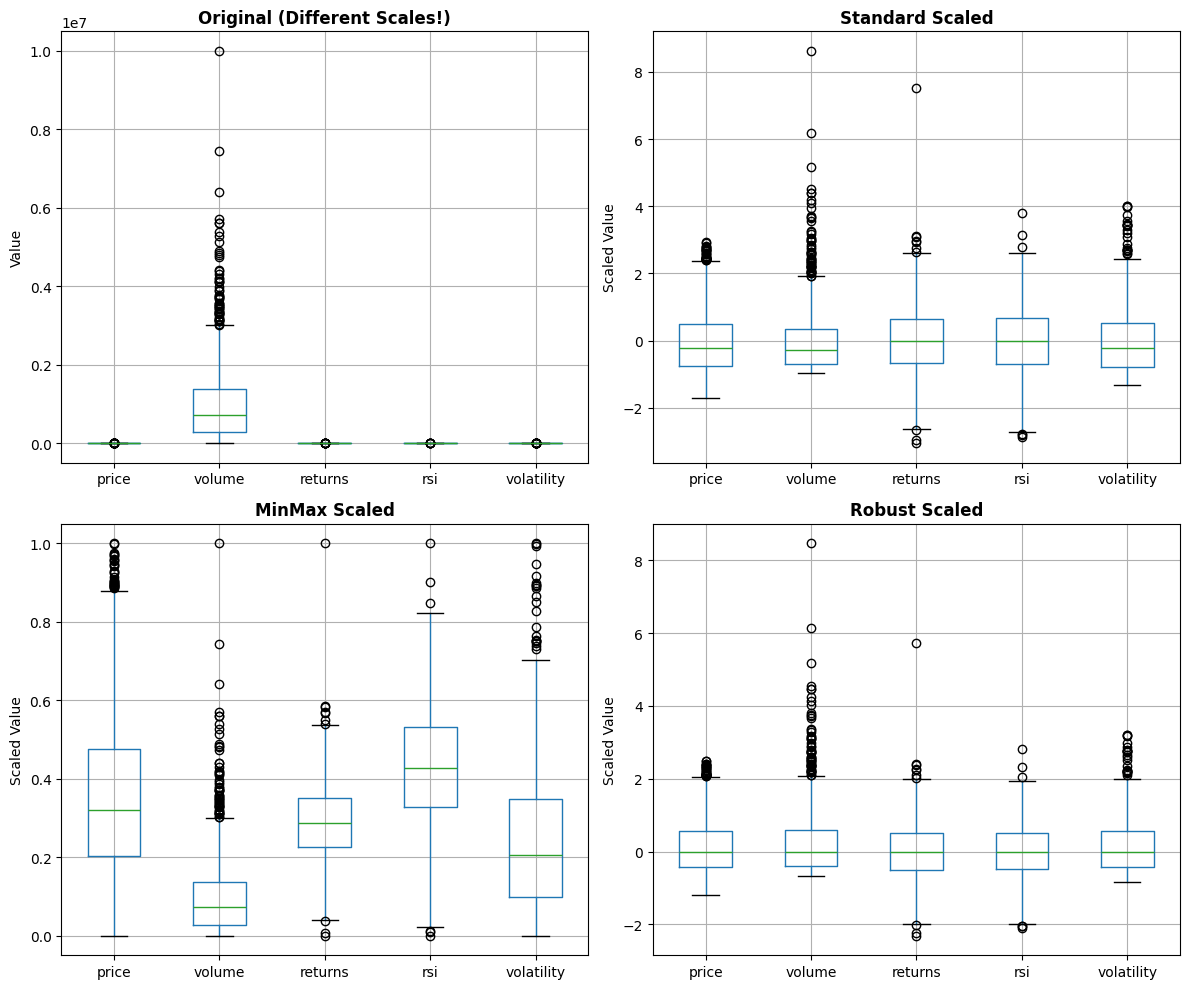


📊 SCALER COMPARISON:
------------------------------------------------------------

Standard:
  Mean range: [-0.00, 0.00]
  Std range:  [1.00, 1.00]

MinMax:
  Mean range: [0.10, 0.43]
  Std range:  [0.09, 0.22]

Robust:
  Mean range: [0.01, 0.26]
  Std range:  [0.74, 0.95]


In [4]:
# Generate synthetic stock data with different scales
print("FEATURE SCALING COMPARISON")
print("="*60)

np.random.seed(42)
n_samples = 1000

# Create features with vastly different scales (like real trading data)
data = pd.DataFrame({
    'price': 100 + np.cumsum(np.random.randn(n_samples) * 2),  # ~100
    'volume': np.random.exponential(1000000, n_samples),  # ~1M
    'returns': np.random.randn(n_samples) * 0.02,  # ~0.02
    'rsi': 50 + np.random.randn(n_samples) * 15,  # ~50
    'volatility': np.abs(np.random.randn(n_samples)) * 0.03,  # ~0.03
})

# Add some outliers
data.loc[100, 'volume'] = 10000000  # Extreme volume
data.loc[500, 'returns'] = 0.15  # Flash crash

print("📊 ORIGINAL DATA STATISTICS:")
print(data.describe().round(2))

# Apply different scalers
scalers = {
    'Standard': StandardScaler(),
    'MinMax': MinMaxScaler(),
    'Robust': RobustScaler()
}

scaled_data = {}
for name, scaler in scalers.items():
    scaled_data[name] = pd.DataFrame(
        scaler.fit_transform(data),
        columns=data.columns
    )

# Visualize
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Original
data.boxplot(ax=axes[0, 0])
axes[0, 0].set_title('Original (Different Scales!)', fontweight='bold')
axes[0, 0].set_ylabel('Value')

# Scaled versions
for ax, (name, df) in zip(axes.flat[1:], scaled_data.items()):
    df.boxplot(ax=ax)
    ax.set_title(f'{name} Scaled', fontweight='bold')
    ax.set_ylabel('Scaled Value')

plt.tight_layout()
plt.show()

print("\n📊 SCALER COMPARISON:")
print("-"*60)
for name, df in scaled_data.items():
    print(f"\n{name}:")
    print(f"  Mean range: [{df.mean().min():.2f}, {df.mean().max():.2f}]")
    print(f"  Std range:  [{df.std().min():.2f}, {df.std().max():.2f}]")

In [5]:
# Why scaling matters for neural networks
print("WHY SCALING MATTERS")
print("="*60)

class SimpleNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(5, 1)
        
    def forward(self, x):
        return self.fc(x)

# Without scaling
torch.manual_seed(42)
model_unscaled = SimpleNN()
X_unscaled = torch.FloatTensor(data.values[:100])
out_unscaled = model_unscaled(X_unscaled)

# With scaling
torch.manual_seed(42)
model_scaled = SimpleNN()
scaler = StandardScaler()
X_scaled = torch.FloatTensor(scaler.fit_transform(data.values[:100]))
out_scaled = model_scaled(X_scaled)

print(f"Unscaled output range: [{out_unscaled.min().item():.2f}, {out_unscaled.max().item():.2f}]")
print(f"Scaled output range:   [{out_scaled.min().item():.2f}, {out_scaled.max().item():.2f}]")

print("\n⚠️  Unscaled data causes:")
print("• Large gradients → Unstable training")
print("• Volume feature dominates learning")
print("• Slow convergence")

WHY SCALING MATTERS
Unscaled output range: [11602.88, 2081913.38]
Scaled output range:   [-1.46, 1.92]

⚠️  Unscaled data causes:
• Large gradients → Unstable training
• Volume feature dominates learning
• Slow convergence


---

## Part 2: Creating Sequences for Time Series

In [6]:
# Sequence creation for LSTM/RNN models
print("SEQUENCE CREATION FOR TIME SERIES")
print("="*60)

def create_sequences(data, seq_length, target_col=None):
    """
    Create sequences for time series prediction.
    
    Args:
        data: numpy array of shape (n_samples, n_features)
        seq_length: number of timesteps in each sequence
        target_col: column index for target (None = predict next value of all)
    
    Returns:
        X: sequences of shape (n_sequences, seq_length, n_features)
        y: targets of shape (n_sequences,) or (n_sequences, n_features)
    """
    X, y = [], []
    
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        if target_col is not None:
            y.append(data[i+seq_length, target_col])
        else:
            y.append(data[i+seq_length])
    
    return np.array(X), np.array(y)

# Example with stock data
# Scale data first
scaler = StandardScaler()
scaled_values = scaler.fit_transform(data.values)

# Create sequences
seq_length = 20  # Use 20 days to predict next day
X_seq, y_seq = create_sequences(scaled_values, seq_length, target_col=0)  # Predict price

print(f"Original data shape: {scaled_values.shape}")
print(f"Sequence X shape: {X_seq.shape}")
print(f"Target y shape: {y_seq.shape}")
print(f"\nInterpretation:")
print(f"• {X_seq.shape[0]} samples")
print(f"• {X_seq.shape[1]} timesteps per sample")
print(f"• {X_seq.shape[2]} features per timestep")

SEQUENCE CREATION FOR TIME SERIES
Original data shape: (1000, 5)
Sequence X shape: (980, 20, 5)
Target y shape: (980,)

Interpretation:
• 980 samples
• 20 timesteps per sample
• 5 features per timestep


SEQUENCE VISUALIZATION


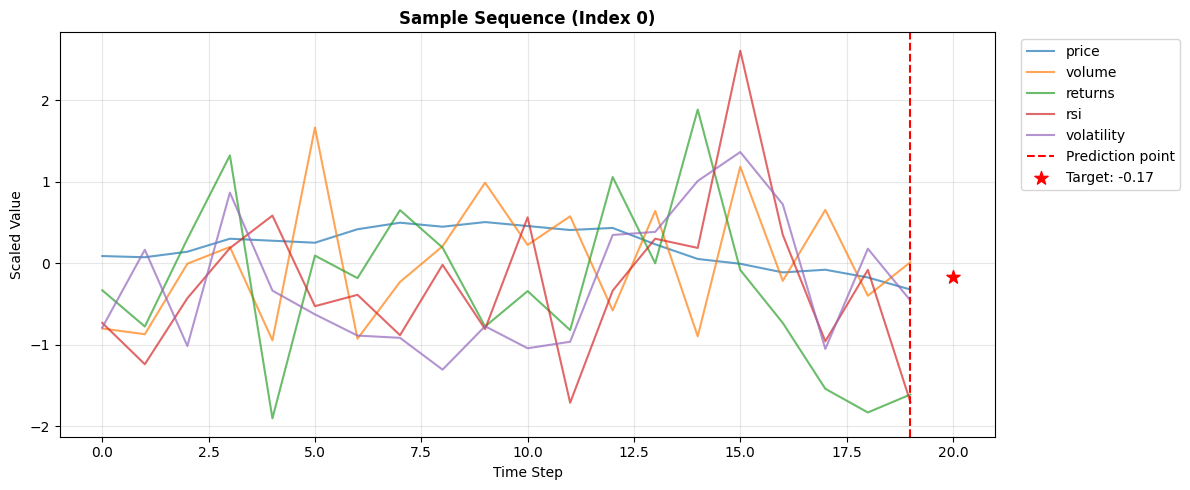


📝 SEQUENCE NOTES:
• Input: 20 timesteps of 5 features each
• Target: Next day's price (scaled)
• Each sample overlaps with neighbors


In [7]:
# Visualize one sequence
print("SEQUENCE VISUALIZATION")
print("="*60)

sample_idx = 0
sample_seq = X_seq[sample_idx]

fig, ax = plt.subplots(figsize=(12, 5))

# Plot sequence features
for i, col in enumerate(data.columns):
    ax.plot(range(seq_length), sample_seq[:, i], label=col, alpha=0.7)

# Mark target
ax.axvline(x=seq_length-1, color='red', linestyle='--', label='Prediction point')
ax.scatter([seq_length], [y_seq[sample_idx]], color='red', s=100, marker='*', 
           label=f'Target: {y_seq[sample_idx]:.2f}', zorder=5)

ax.set_xlabel('Time Step')
ax.set_ylabel('Scaled Value')
ax.set_title(f'Sample Sequence (Index {sample_idx})', fontweight='bold')
ax.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📝 SEQUENCE NOTES:")
print("• Input: 20 timesteps of 5 features each")
print("• Target: Next day's price (scaled)")
print("• Each sample overlaps with neighbors")

---

## Part 3: PyTorch Dataset and DataLoader

In [8]:
# Custom Dataset class
print("PYTORCH DATASET CLASS")
print("="*60)

class StockDataset(Dataset):
    """
    Custom PyTorch Dataset for stock data sequences.
    """
    def __init__(self, data, seq_length, target_col=0):
        self.data = data
        self.seq_length = seq_length
        self.target_col = target_col
        
    def __len__(self):
        return len(self.data) - self.seq_length
    
    def __getitem__(self, idx):
        # Get sequence
        seq = self.data[idx:idx+self.seq_length]
        # Get target (next day's value)
        target = self.data[idx+self.seq_length, self.target_col]
        
        return torch.FloatTensor(seq), torch.FloatTensor([target])

# Create dataset
dataset = StockDataset(scaled_values, seq_length=20, target_col=0)

print(f"Dataset length: {len(dataset)}")
print(f"\nSample output:")
seq, target = dataset[0]
print(f"  Sequence shape: {seq.shape}")
print(f"  Target shape: {target.shape}")
print(f"  Target value: {target.item():.4f}")

PYTORCH DATASET CLASS
Dataset length: 980

Sample output:
  Sequence shape: torch.Size([20, 5])
  Target shape: torch.Size([1])
  Target value: -0.1686


In [9]:
# DataLoader for batching
print("DATALOADER FOR BATCHING")
print("="*60)

# Create DataLoader
batch_size = 32
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,  # Shuffle for training
    drop_last=True  # Drop incomplete batches
)

print(f"Batch size: {batch_size}")
print(f"Number of batches: {len(dataloader)}")

# Get one batch
for batch_X, batch_y in dataloader:
    print(f"\nBatch X shape: {batch_X.shape}")
    print(f"Batch y shape: {batch_y.shape}")
    break

print("\n📝 DATALOADER BENEFITS:")
print("• Automatic batching")
print("• Shuffling between epochs")
print("• Multi-worker data loading")
print("• Memory efficient (lazy loading)")

DATALOADER FOR BATCHING
Batch size: 32
Number of batches: 30

Batch X shape: torch.Size([32, 20, 5])
Batch y shape: torch.Size([32, 1])

📝 DATALOADER BENEFITS:
• Automatic batching
• Shuffling between epochs
• Multi-worker data loading
• Memory efficient (lazy loading)


---

## Part 4: Train/Validation/Test Splits for Time Series

⚠️ **Important**: For time series, we can't randomly shuffle! We need temporal splits.

TIME SERIES SPLIT (NO DATA LEAKAGE!)
Total samples: 1000
Train samples: 700 (70%)
Val samples:   150 (15%)
Test samples:  150 (15%)


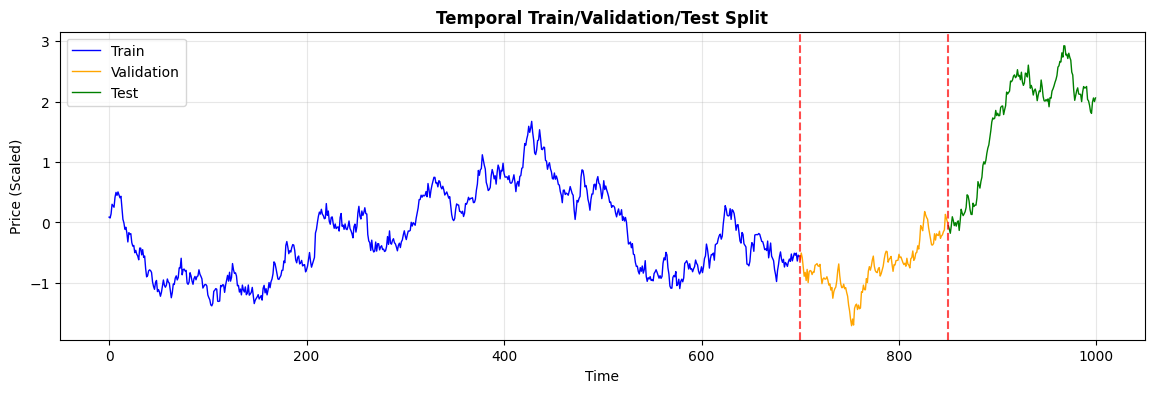


⚠️  CRITICAL FOR TIME SERIES:
• Train on PAST data only
• Validate/Test on FUTURE data
• Never shuffle across time!


In [10]:
# Proper time series split
print("TIME SERIES SPLIT (NO DATA LEAKAGE!)")
print("="*60)

def temporal_train_val_test_split(data, train_ratio=0.7, val_ratio=0.15):
    """
    Split time series data chronologically.
    
    Train | Validation | Test
    [-----|------------|----]
     70%      15%        15%
    """
    n = len(data)
    train_end = int(n * train_ratio)
    val_end = int(n * (train_ratio + val_ratio))
    
    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]
    
    return train_data, val_data, test_data

# Split the data
train_data, val_data, test_data = temporal_train_val_test_split(scaled_values)

print(f"Total samples: {len(scaled_values)}")
print(f"Train samples: {len(train_data)} ({len(train_data)/len(scaled_values)*100:.0f}%)")
print(f"Val samples:   {len(val_data)} ({len(val_data)/len(scaled_values)*100:.0f}%)")
print(f"Test samples:  {len(test_data)} ({len(test_data)/len(scaled_values)*100:.0f}%)")

# Visualize split
plt.figure(figsize=(14, 4))

# Plot price feature
train_idx = range(len(train_data))
val_idx = range(len(train_data), len(train_data) + len(val_data))
test_idx = range(len(train_data) + len(val_data), len(scaled_values))

plt.plot(train_idx, train_data[:, 0], 'b-', label='Train', linewidth=1)
plt.plot(val_idx, val_data[:, 0], 'orange', label='Validation', linewidth=1)
plt.plot(test_idx, test_data[:, 0], 'g-', label='Test', linewidth=1)

plt.axvline(x=len(train_data), color='red', linestyle='--', alpha=0.7)
plt.axvline(x=len(train_data)+len(val_data), color='red', linestyle='--', alpha=0.7)

plt.xlabel('Time')
plt.ylabel('Price (Scaled)')
plt.title('Temporal Train/Validation/Test Split', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("\n⚠️  CRITICAL FOR TIME SERIES:")
print("• Train on PAST data only")
print("• Validate/Test on FUTURE data")
print("• Never shuffle across time!")

In [11]:
# Create datasets and dataloaders for each split
print("CREATING SPLIT DATASETS")
print("="*60)

# Scale using ONLY training data statistics!
scaler = StandardScaler()
train_scaled = scaler.fit_transform(data.values[:700])  # Fit on train only
val_scaled = scaler.transform(data.values[700:850])  # Transform val
test_scaled = scaler.transform(data.values[850:])  # Transform test

print("✅ Scaler fit on training data only (no data leakage!)")

# Create datasets
seq_length = 20
train_dataset = StockDataset(train_scaled, seq_length)
val_dataset = StockDataset(val_scaled, seq_length)
test_dataset = StockDataset(test_scaled, seq_length)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)  # Don't shuffle val/test!
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(f"\nTrain batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

CREATING SPLIT DATASETS
✅ Scaler fit on training data only (no data leakage!)

Train batches: 22
Val batches: 5
Test batches: 5


---

## Part 5: Walk-Forward Validation

WALK-FORWARD VALIDATION


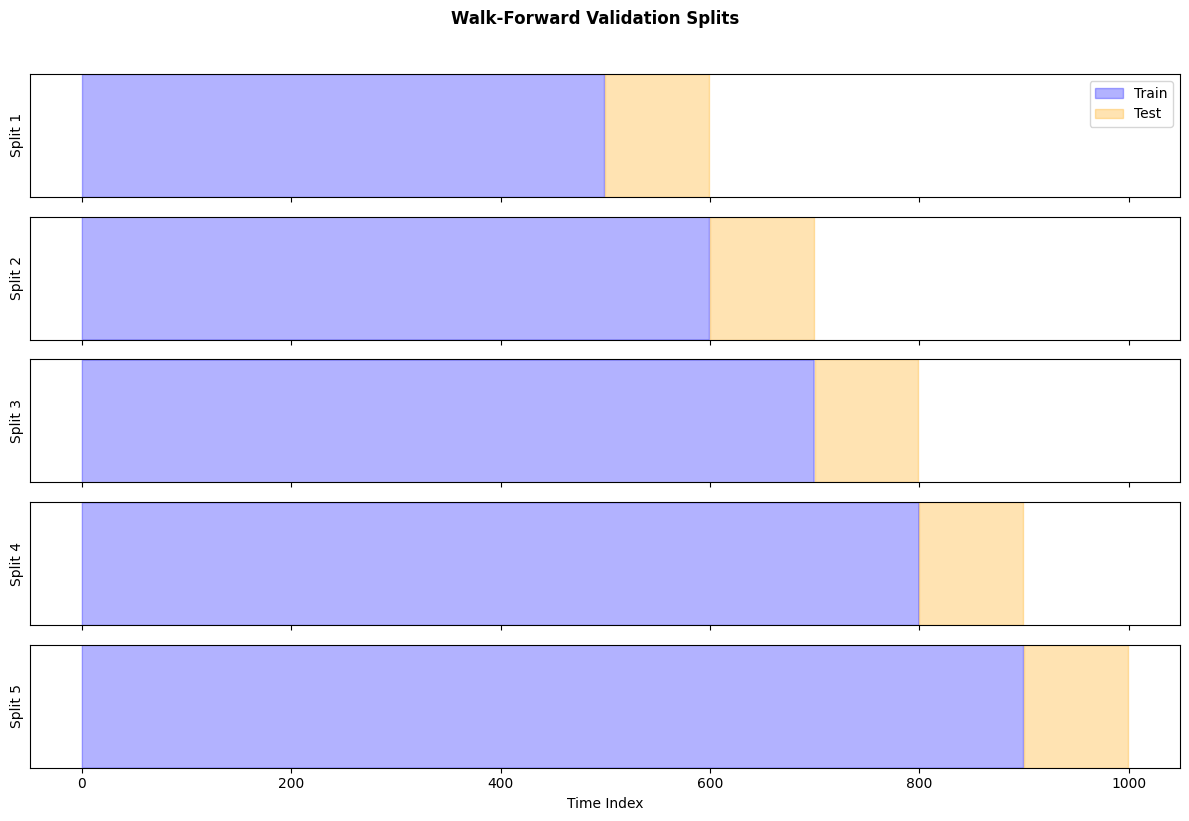


📊 WALK-FORWARD BENEFITS:
• Tests on multiple time periods
• More robust performance estimation
• Simulates real trading deployment


In [12]:
# Walk-forward validation (expanding window)
print("WALK-FORWARD VALIDATION")
print("="*60)

def walk_forward_splits(data, n_splits=5, test_size=50):
    """
    Create walk-forward validation splits.
    
    Split 1: [Train---------][Test]
    Split 2: [Train-------------][Test]
    Split 3: [Train-----------------][Test]
    ...
    """
    splits = []
    n = len(data)
    
    for i in range(n_splits):
        test_end = n - (n_splits - i - 1) * test_size
        test_start = test_end - test_size
        train_end = test_start
        
        if train_end > test_size:  # Ensure enough training data
            splits.append({
                'train': (0, train_end),
                'test': (test_start, test_end)
            })
    
    return splits

# Create walk-forward splits
wf_splits = walk_forward_splits(scaled_values, n_splits=5, test_size=100)

# Visualize
fig, axes = plt.subplots(len(wf_splits), 1, figsize=(12, 8), sharex=True)

for i, (ax, split) in enumerate(zip(axes, wf_splits)):
    train_start, train_end = split['train']
    test_start, test_end = split['test']
    
    # Plot
    ax.fill_between(range(train_start, train_end), 0, 1, alpha=0.3, color='blue', label='Train')
    ax.fill_between(range(test_start, test_end), 0, 1, alpha=0.3, color='orange', label='Test')
    ax.set_ylabel(f'Split {i+1}')
    ax.set_ylim(0, 1)
    ax.set_yticks([])
    if i == 0:
        ax.legend(loc='upper right')

axes[-1].set_xlabel('Time Index')
plt.suptitle('Walk-Forward Validation Splits', fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print("\n📊 WALK-FORWARD BENEFITS:")
print("• Tests on multiple time periods")
print("• More robust performance estimation")
print("• Simulates real trading deployment")

---

## Part 6: Complete Preprocessing Pipeline

In [13]:
# Complete preprocessing pipeline class
print("COMPLETE PREPROCESSING PIPELINE")
print("="*60)

class TradingDataPipeline:
    """
    Complete data preprocessing pipeline for trading models.
    """
    
    def __init__(self, seq_length=20, scaler_type='standard'):
        self.seq_length = seq_length
        self.scaler_type = scaler_type
        self.scaler = None
        self.feature_names = None
        
    def fit_transform(self, df, target_col='returns'):
        """
        Fit scaler and transform data.
        Call this on TRAINING data only!
        """
        self.feature_names = df.columns.tolist()
        self.target_col_idx = self.feature_names.index(target_col)
        
        # Initialize scaler
        if self.scaler_type == 'standard':
            self.scaler = StandardScaler()
        elif self.scaler_type == 'minmax':
            self.scaler = MinMaxScaler()
        elif self.scaler_type == 'robust':
            self.scaler = RobustScaler()
        
        # Fit and transform
        scaled = self.scaler.fit_transform(df.values)
        return self._create_sequences(scaled)
    
    def transform(self, df):
        """
        Transform data using fitted scaler.
        Call this on VALIDATION/TEST data.
        """
        if self.scaler is None:
            raise ValueError("Must call fit_transform first!")
        
        scaled = self.scaler.transform(df.values)
        return self._create_sequences(scaled)
    
    def _create_sequences(self, data):
        """Create sequences for time series."""
        X, y = [], []
        for i in range(len(data) - self.seq_length):
            X.append(data[i:i+self.seq_length])
            y.append(data[i+self.seq_length, self.target_col_idx])
        return np.array(X), np.array(y)
    
    def get_dataloaders(self, train_df, val_df, test_df, 
                        target_col='returns', batch_size=32):
        """
        Complete pipeline: fit, transform, create dataloaders.
        """
        # Fit and transform training data
        X_train, y_train = self.fit_transform(train_df, target_col)
        
        # Transform val/test (using training statistics)
        X_val, y_val = self.transform(val_df)
        X_test, y_test = self.transform(test_df)
        
        # Create tensors
        train_dataset = TensorDataset(
            torch.FloatTensor(X_train),
            torch.FloatTensor(y_train).unsqueeze(1)
        )
        val_dataset = TensorDataset(
            torch.FloatTensor(X_val),
            torch.FloatTensor(y_val).unsqueeze(1)
        )
        test_dataset = TensorDataset(
            torch.FloatTensor(X_test),
            torch.FloatTensor(y_test).unsqueeze(1)
        )
        
        # Create dataloaders
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
        
        return train_loader, val_loader, test_loader

# Use the pipeline
pipeline = TradingDataPipeline(seq_length=20, scaler_type='standard')

# Split data
train_df = data.iloc[:700]
val_df = data.iloc[700:850]
test_df = data.iloc[850:]

# Get dataloaders
train_loader, val_loader, test_loader = pipeline.get_dataloaders(
    train_df, val_df, test_df,
    target_col='returns',
    batch_size=32
)

print("✅ Pipeline complete!")
print(f"\nDataLoader sizes:")
print(f"  Train: {len(train_loader)} batches")
print(f"  Val:   {len(val_loader)} batches")
print(f"  Test:  {len(test_loader)} batches")

# Verify shapes
for X, y in train_loader:
    print(f"\nBatch shapes:")
    print(f"  X: {X.shape} = (batch, seq_len, features)")
    print(f"  y: {y.shape} = (batch, 1)")
    break

COMPLETE PREPROCESSING PIPELINE
✅ Pipeline complete!

DataLoader sizes:
  Train: 22 batches
  Val:   5 batches
  Test:  5 batches

Batch shapes:
  X: torch.Size([32, 20, 5]) = (batch, seq_len, features)
  y: torch.Size([32, 1]) = (batch, 1)


---

## 📝 Day 6 Summary

### Preprocessing Checklist:

1. **Scaling** (fit on train only!):
   - StandardScaler for most cases
   - RobustScaler for outliers
   - MinMaxScaler for bounded outputs

2. **Sequences**:
   - Shape: (samples, seq_length, features)
   - Target: next timestep value

3. **Splits** (temporal!):
   - Train → Validate → Test
   - Never shuffle across time
   - Walk-forward for robustness

4. **DataLoader**:
   - Shuffle train only
   - Batch size 16-64 typically

In [14]:
print("""
╔══════════════════════════════════════════════════════════════════╗
║         DAY 6 COMPLETE: DATA PREPROCESSING                       ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Feature scaling (Standard, MinMax, Robust)                   ║
║  ✓ Sequence creation for time series                            ║
║  ✓ PyTorch Dataset and DataLoader                               ║
║  ✓ Temporal train/val/test splits                               ║
║  ✓ Walk-forward validation                                      ║
║  ✓ Complete preprocessing pipeline                              ║
╚══════════════════════════════════════════════════════════════════╝
""")


╔══════════════════════════════════════════════════════════════════╗
║         DAY 6 COMPLETE: DATA PREPROCESSING                       ║
╠══════════════════════════════════════════════════════════════════╣
║  ✓ Feature scaling (Standard, MinMax, Robust)                   ║
║  ✓ Sequence creation for time series                            ║
║  ✓ PyTorch Dataset and DataLoader                               ║
║  ✓ Temporal train/val/test splits                               ║
║  ✓ Walk-forward validation                                      ║
║  ✓ Complete preprocessing pipeline                              ║
╚══════════════════════════════════════════════════════════════════╝

